# Transfer Learning with Pytorch

Transfer learning is a machine learning technique where a pre-trained model, which has been trained on a large dataset for a specific task, is repurposed as the starting point for training a new model on a different but related task.

Transfer learning offers several advantages:
- **Faster Training**
- **Better Performance**
- **Feature Extraction**
- **Domain Adaptation**

PyTorch is a popular deep learning framework that is well-suited for transfer learning, and here's why you might choose to use PyTorch for this purpose:
- **Dynamic Computation Graph**
- **Large Pre-trained Model Collection**
- **Flexible and Intuitive API**
- **Active Research Community**

In summary, transfer learning is a powerful technique for leveraging pre-trained models to solve new tasks, and PyTorch's dynamic nature, pre-trained model collection, and ease of use make it a suitable choice for implementing transfer learning workflows.

## About Dataset

**Food Image Classification Dataset**
- The dataset contains **19K** unique images obtained from various Google resources
- Focuses on **17 varieties** of Western appetizers
- Meticulously curated images ensuring diversity and representativeness
- Provides a solid foundation for developing robust and precise image classification algorithms
- Encourages exploration in the fascinating field of food image classification

## Import Library

In [90]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import os
import torchvision

import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [99]:
INPUT_PATH = 'data'
TRAIN_PATH = 'data/train'
TEST_PATH = 'data/test'
VALIDATION_PATH = 'data/val'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       normalize])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       normalize])

image_datasets = {
    'train': datasets.ImageFolder(TRAIN_PATH, train_transforms),
    'validation': datasets.ImageFolder(VALIDATION_PATH, test_transforms),
    'test' : datasets.ImageFolder(TEST_PATH, test_transforms)
}

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=64,shuffle=True)
val_loader = torch.utils.data.DataLoader(image_datasets['validation'], batch_size=64,shuffle=False)
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=64,shuffle=False)

## Inspect Data

### Data Count

In [92]:
# Train Count
print("Data Count")
print("----------")
print(f"Training total   : {len(train_loader.dataset)}")
print(f"Validation total : {len(val_loader.dataset)}")
print(f"Testing total    : {len(test_loader.dataset)}")

Data Count
----------
Training total   : 15202
Validation total : 1899
Testing total    : 1903


### Images Preview

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


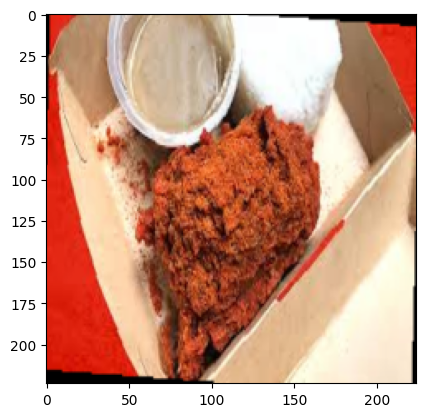

In [103]:
X_batch, y_batch = next(iter(train_loader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[1].permute(1, 2, 0).numpy() * std + mean)